18 jan 2024
plots for leave one out cross validation

In [1]:
import os

In [2]:
import sys
print(sys.executable)

/usr/bin/python3


In [3]:
from pythonimports import *
from pythonimports.myfigs import save_pdf
from pythonimports.mymaps import *

import pandas as pd
import xarray
import rioxarray
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, linregress, kendalltau
import scipy.odr as odr  # orthogonal distance regression
import scipy
import seaborn as sns
from numpy.linalg import norm
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [4]:
for module_name in sys.modules:
     print(module_name)

sys
builtins
_frozen_importlib
_imp
_thread
_warnings
_weakref
_io
marshal
posix
_frozen_importlib_external
time
zipimport
_codecs
codecs
encodings.aliases
encodings
encodings.utf_8
_signal
encodings.latin_1
_abc
abc
io
__main__
_stat
stat
_collections_abc
genericpath
posixpath
os.path
os
_sitebuiltins
_locale
_bootlocale
types
importlib._bootstrap
importlib._bootstrap_external
warnings
importlib
importlib.machinery
_heapq
heapq
itertools
keyword
_operator
operator
reprlib
_collections
collections
collections.abc
_functools
functools
contextlib
enum
_sre
sre_constants
sre_parse
sre_compile
copyreg
re
typing.io
typing.re
typing
importlib.abc
importlib.util
mpl_toolkits
site
_weakrefset
weakref
pkgutil
runpy
ipykernel._version
_json
json.scanner
json.decoder
json.encoder
json
errno
signal
threading
pwd
grp
_posixsubprocess
select
math
selectors
subprocess
jupyter_client._version
platform
_ctypes
_struct
struct
ctypes._endian
ctypes
zmq.backend.select
_cython_0_29_32
cython_runtime
zmq.er

In [7]:
os.getcwd() 

'/local/workdir/kcarbeck'

## 1. import data
### import population envdata

In [8]:
envdata = pd.read_csv('/workdir/kcarbeck/data/envdir/envfile_full.txt', skipinitialspace=True)
envdata.index = envdata['Population'].tolist()
envdata = envdata.drop('Population', axis=1)
envdata.head()

,LONG,LAT,MAT,TD,MSP,SHM,DD_0,DD18,EMT,RH
adusta_MX,-101.047444,19.934906,1.169345,-1.640459,0.709734,-0.593684,-0.894018,0.401694,0.797341,-1.174676
caurina_AK,-145.403889,60.417500,-1.502225,0.258751,2.452379,-0.616611,2.378720,-0.794085,-1.300524,0.792773
cleonensis_CA,-123.506310,41.432910,0.330344,0.249139,-0.522428,-0.466447,-0.633935,0.152866,0.374323,-0.246761
fallax_AZ,-110.140057,31.555623,1.224925,0.485066,-0.284462,-0.506447,-0.832533,1.356705,0.265468,-0.986404
fallax_CA,-115.617300,33.165800,2.236954,0.875000,-0.877947,1.694292,-0.890790,3.816125,1.262729,-0.927568


### import eBird trend data

In [9]:
trends = pd.read_csv('/workdir/kcarbeck/data/eBird/trends/SOSP_eBird_trends_2012_2022.csv')
columns_to_drop = ['Unnamed: 0', 'species_code', 'season']
columns_to_drop = [col for col in columns_to_drop if col in trends.columns]
trends = trends.drop(columns_to_drop, axis=1)

trends.rename(columns={'longitude': 'LONG', 'latitude': 'LAT'}, inplace=True)

trends.head()

,start_year,end_year,start_date,end_date,srd_id,LONG,LAT,abd,abd_ppy,abd_ppy_lower,abd_ppy_upper,abd_ppy_nonzero,abd_trend,abd_trend_lower,abd_trend_upper
0,2012,2022,05-31,07-12,177687,-151.228061,61.582946,0.000550,-0.684269,-2.211404,0.702132,False,-6.635788,-20.038284,7.247370
1,2012,2022,05-31,07-12,177690,-149.716315,61.582946,0.004486,-1.047640,-2.145068,0.073457,False,-9.996047,-19.494195,0.736998
2,2012,2022,05-31,07-12,177691,-149.212400,61.582946,0.026318,0.105174,-1.179777,1.801912,False,1.056728,-11.190727,19.552693
3,2012,2022,05-31,07-12,179188,-150.568612,61.343140,0.002229,-0.823762,-2.158519,0.467470,False,-7.938872,-19.604790,4.774271
4,2012,2022,05-31,07-12,179189,-150.068561,61.343140,0.003722,-0.751236,-1.608475,1.288589,False,-7.263421,-14.969074,13.659361


### extract offset values

In [11]:
import rasterio
from rasterio.plot import show
from matplotlib.colors import Normalize

In [21]:
# read in full offset
with rasterio.open("data/fitting/west_full_offset.tif") as src:
    full_offset = src.read(1)  #first band

rasters = {'full_offset': full_offset.flatten()}  # flatten the array and add to dictionary

In [22]:
# read in LOOCV offsets
directory = 'data/loocv/fitting/'

# list all .tif files
tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]

for tif_file in tif_files:
    # Extract the population name and construct the variable name
    population_name = tif_file.replace('west_loocv_', '').replace('_offset.tif', '')
    variable_name = f"{population_name}_offset"

    # Open the raster file and read the data
    raster_path = os.path.join(directory, tif_file)
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band
        rasters[variable_name] = raster_data.flatten()  # Flatten and add to dictionary
        
# Now you can access each raster by its population name, e.g., rasters['sanaka_AK_offset']


In [23]:
for key in rasters.keys():
    print(key)

full_offset
montana_OR_offset
adusta_MX_offset
maxima_AK_offset
insignis_AK_offset
fallax_UT_offset
fallax_CA_offset
heermanni_N_CA_offset
samuelis_CA_offset
sanaka_AK_offset
montana_NV_offset
montana_S_CA_offset
rivularis_MX_offset
montana_N_CA_offset
fallax_AZ_offset
merrilli_AK_offset
pusillula_CA_offset
merrilli_WA_offset
gouldii_CA_offset
graminea_CA_offset
mexicana_MX_offset
maxillaris_CA_offset
caurina_AK_offset
rufina_BC_offset
heermanni_S_CA_offset
kenaiensis_AK_offset
cleonensis_CA_offset
nominate_ON_offset
morphna_BC_offset
nominate_VA_offset


/home/kcarbeck/.local/lib/python3.9/site-packages/matplotlib/image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
/home/kcarbeck/.local/lib/python3.9/site-packages/matplotlib/image.py:500: RuntimeWarning: overflow encountered in divide
  vrange /= ((a_max - a_min) / frac)
/home/kcarbeck/.local/lib/python3.9/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


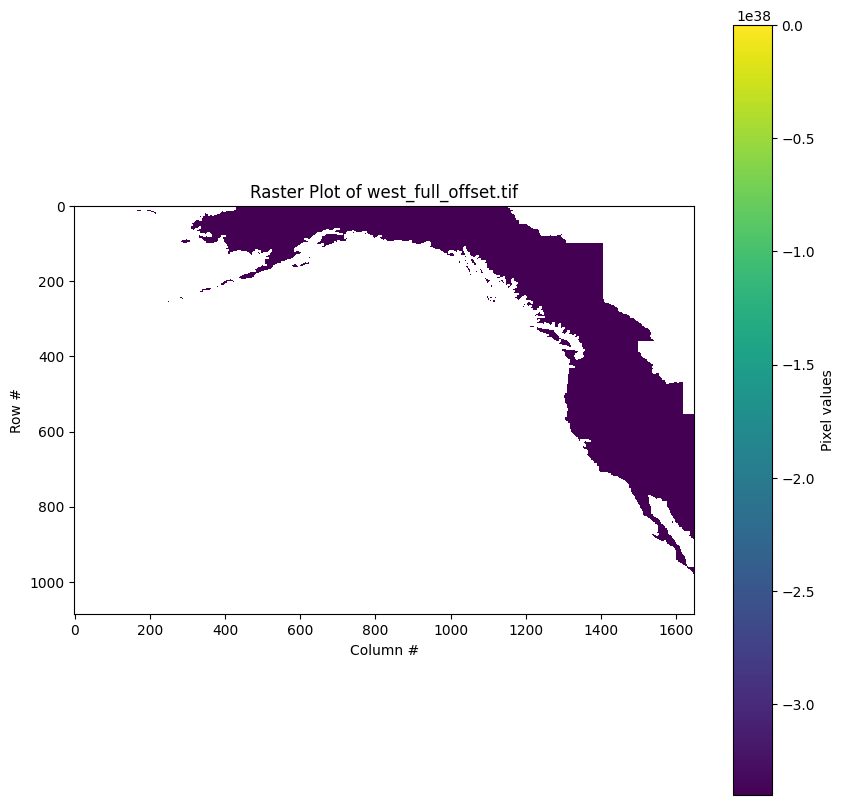

In [15]:
with rasterio.open("data/fitting/west_full_offset.tif") as src:
    band1 = src.read(1)
    nodata = src.nodata
    # Mask the "no data" values
    band1_masked = np.ma.masked_where(band1 == nodata, band1)

    plt.figure(figsize=(10, 10))
    # Use the masked array to plot
    img = plt.imshow(band1_masked, cmap='viridis', norm=Normalize(vmin=band1.min(), vmax=band1.max(), clip=True))
    plt.title("Raster Plot of west_full_offset.tif")
    plt.xlabel("Column #")
    plt.ylabel("Row #")
    plt.colorbar(img, label='Pixel values', orientation='vertical')
    plt.show()

## 2. CV consistentency
To assess the consistency of leave one out models, you can compare their predictions. Assuming you have a dataset with actual values and predictions from each model

In [24]:
# Get NA value
with rasterio.open("data/loocv/fitting/west_loocv_maxillaris_CA_offset.tif") as src:
    nodata = src.nodatavals
    nodata_value = nodata[0] if nodata else None

In [26]:
# Create a DataFrame from the raster dictionary
offset = pd.DataFrame(rasters)

# Handle "no data" values
offset.replace(nodata_value, np.nan, inplace=True)

# Drop rows with any NaN values
offset.dropna(inplace=True)

# Display the first few rows of the DataFrame
offset.head()

,full_offset,montana_OR_offset,adusta_MX_offset,maxima_AK_offset,insignis_AK_offset,fallax_UT_offset,fallax_CA_offset,heermanni_N_CA_offset,samuelis_CA_offset,sanaka_AK_offset,...,mexicana_MX_offset,maxillaris_CA_offset,caurina_AK_offset,rufina_BC_offset,heermanni_S_CA_offset,kenaiensis_AK_offset,cleonensis_CA_offset,nominate_ON_offset,morphna_BC_offset,nominate_VA_offset
426,0.005658,0.005656,0.005054,0.007504,0.007453,0.005736,0.005846,0.005518,0.005453,0.003706,...,0.004938,0.005457,0.005669,0.006114,0.005551,0.005138,0.005412,0.009243,0.005813,0.005896
427,0.005829,0.005845,0.005239,0.007619,0.007683,0.005896,0.006014,0.005684,0.005623,0.003881,...,0.005105,0.005623,0.006110,0.006369,0.005723,0.005282,0.005583,0.009190,0.005715,0.006050
428,0.005594,0.005676,0.005078,0.006967,0.007279,0.005656,0.005823,0.005466,0.005412,0.003806,...,0.004927,0.005409,0.006593,0.006357,0.005516,0.004775,0.005383,0.007793,0.005656,0.005709
429,0.003839,0.003914,0.003281,0.005054,0.005110,0.003950,0.004065,0.003749,0.003689,0.003170,...,0.003285,0.003706,0.004604,0.004523,0.003233,0.003190,0.003682,0.004903,0.003908,0.003768
430,0.004900,0.004991,0.004481,0.005815,0.006021,0.005030,0.005110,0.004815,0.004758,0.004224,...,0.004349,0.004762,0.004840,0.004910,0.004172,0.003167,0.004740,0.005583,0.004235,0.005000


In [27]:
# Calculate the correlation matrix
correlation_matrix = offset.corr()

# Print the correlation matrix
correlation_matrix.head()

,full_offset,montana_OR_offset,adusta_MX_offset,maxima_AK_offset,insignis_AK_offset,fallax_UT_offset,fallax_CA_offset,heermanni_N_CA_offset,samuelis_CA_offset,sanaka_AK_offset,...,mexicana_MX_offset,maxillaris_CA_offset,caurina_AK_offset,rufina_BC_offset,heermanni_S_CA_offset,kenaiensis_AK_offset,cleonensis_CA_offset,nominate_ON_offset,morphna_BC_offset,nominate_VA_offset
full_offset,1.000000,0.993692,0.990787,0.992677,0.995895,0.999609,0.989049,0.999525,0.998017,0.997815,...,0.989706,0.994958,0.970873,0.997273,0.999152,0.997299,0.998752,0.990478,0.997885,0.997883
montana_OR_offset,0.993692,1.000000,0.984824,0.986298,0.988786,0.993132,0.983035,0.993177,0.991877,0.991600,...,0.984692,0.988557,0.963832,0.990904,0.992787,0.990989,0.992380,0.983966,0.990889,0.990364
adusta_MX_offset,0.990787,0.984824,1.000000,0.980221,0.986166,0.990256,0.981331,0.990930,0.989941,0.987748,...,0.994091,0.985273,0.958914,0.988382,0.990679,0.987148,0.990160,0.978540,0.987925,0.986517
maxima_AK_offset,0.992677,0.986298,0.980221,1.000000,0.990233,0.992404,0.981740,0.992114,0.991039,0.991308,...,0.982383,0.987852,0.961050,0.989085,0.992097,0.990255,0.991942,0.985547,0.988996,0.990894
insignis_AK_offset,0.995895,0.988786,0.986166,0.990233,1.000000,0.996038,0.983450,0.994792,0.993682,0.995423,...,0.983127,0.990826,0.969549,0.993095,0.994583,0.993697,0.994988,0.988475,0.994166,0.994906


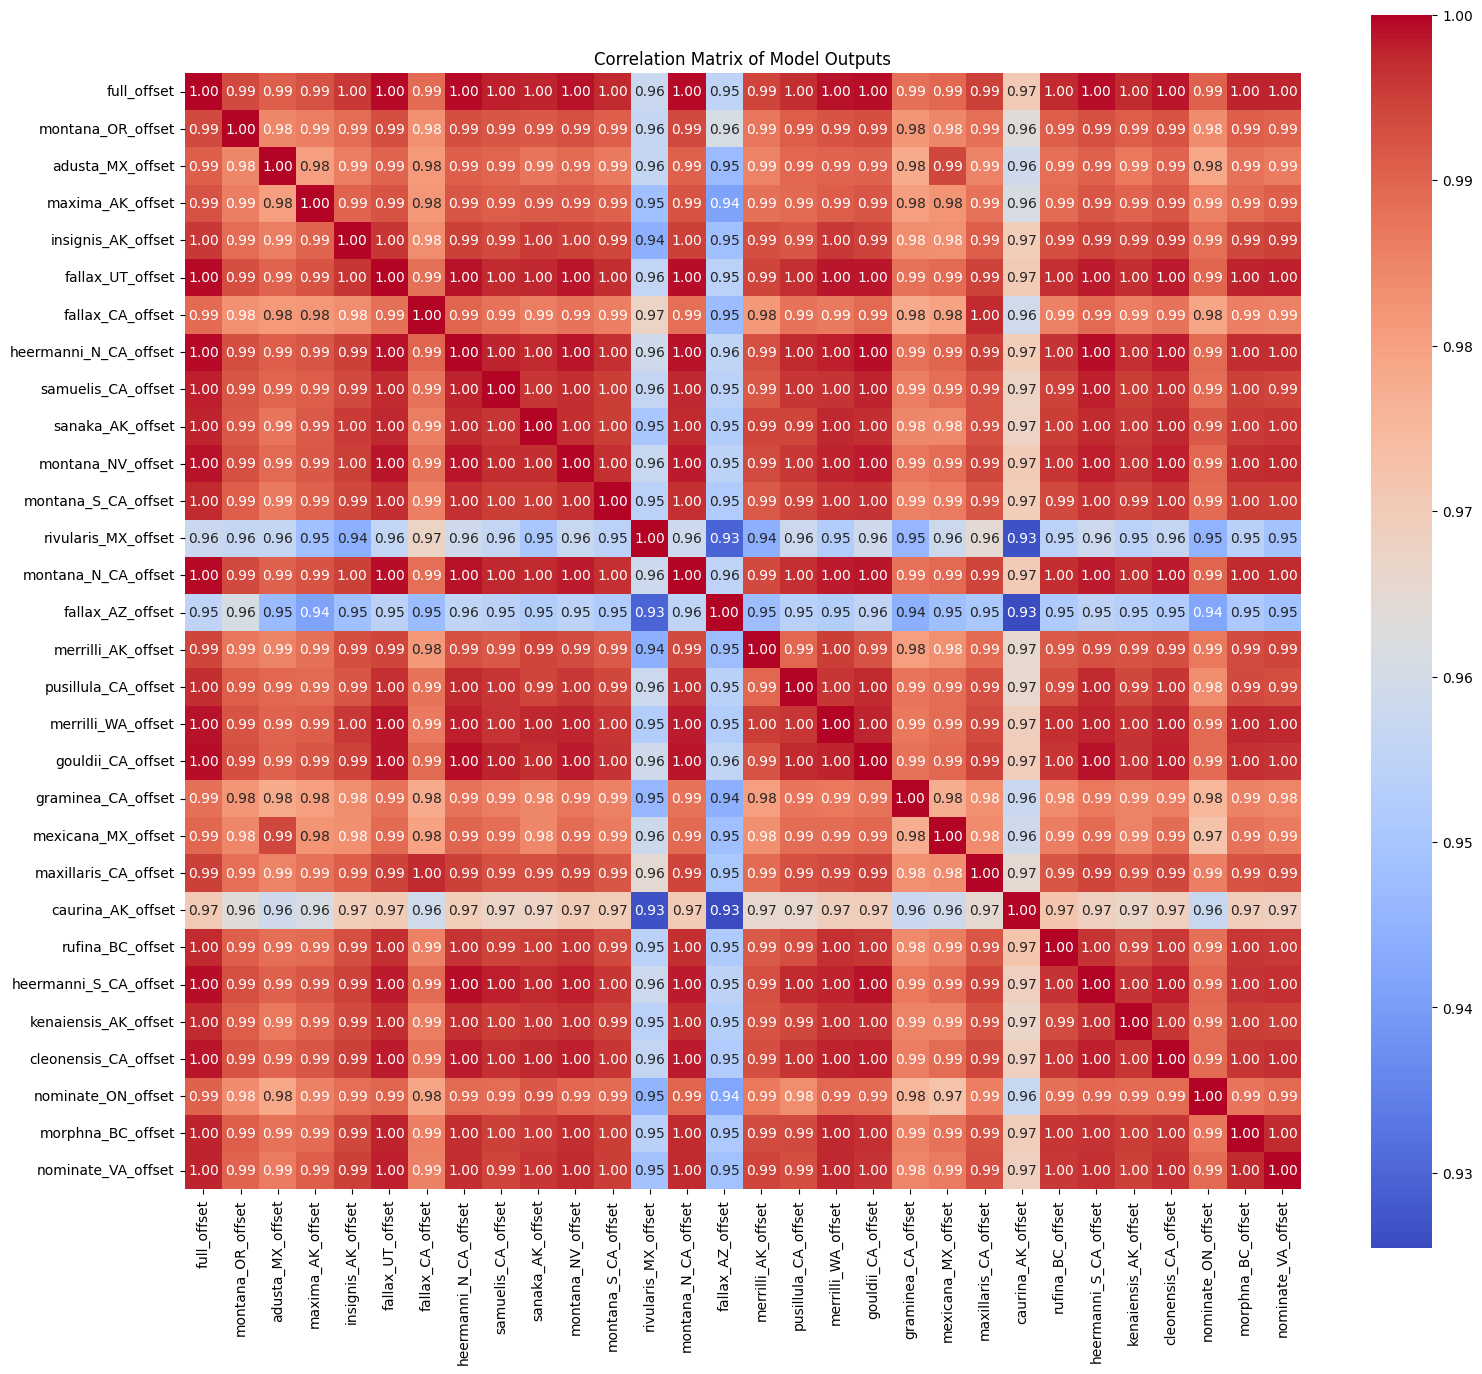

In [31]:
# Create a heatmap from the correlation matrix
plt.figure(figsize=(16, 14))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar=True, square=True)

# Give a title to the heatmap
plt.title('Correlation Matrix of Model Outputs')

# Adjust layout for better fit and display the plot
plt.tight_layout()
plt.show()

### 3. Comparison with Full Model 
To compare K-fold models with the full model, calculate similarity metrics like correlation, MSE, or MAE:

In [33]:
# get the list of column names except for the full model prediction
pop_columns = offset.columns[1:]  # Exclude the first column which is 'full_offset'

# Iterate over the K-fold prediction columns to compare them with the full model predictions
for pred_col in pop_columns:
    correlation = np.corrcoef(offset[pred_col], offset['full_offset'])[0, 1]
    mse = np.mean((offset[pred_col] - offset['full_offset']) ** 2)
    mae = np.mean(np.abs(offset[pred_col] - offset['full_offset']))

    print(f"{pred_col}: Correlation = {correlation:.6f}, MSE = {mse:.6f}, MAE = {mae:.6f}")


montana_OR_offset: Correlation = 0.993692, MSE = 0.000001, MAE = 0.000363
adusta_MX_offset: Correlation = 0.990787, MSE = 0.000002, MAE = 0.000684
maxima_AK_offset: Correlation = 0.992677, MSE = 0.000002, MAE = 0.000622
insignis_AK_offset: Correlation = 0.995895, MSE = 0.000001, MAE = 0.000416
fallax_UT_offset: Correlation = 0.999609, MSE = 0.000000, MAE = 0.000147
fallax_CA_offset: Correlation = 0.989049, MSE = 0.000002, MAE = 0.000356
heermanni_N_CA_offset: Correlation = 0.999525, MSE = 0.000000, MAE = 0.000155
samuelis_CA_offset: Correlation = 0.998017, MSE = 0.000000, MAE = 0.000288
sanaka_AK_offset: Correlation = 0.997815, MSE = 0.000001, MAE = 0.000482
montana_NV_offset: Correlation = 0.999109, MSE = 0.000000, MAE = 0.000225
montana_S_CA_offset: Correlation = 0.997247, MSE = 0.000000, MAE = 0.000261
rivularis_MX_offset: Correlation = 0.957537, MSE = 0.000023, MAE = 0.001225
montana_N_CA_offset: Correlation = 0.999522, MSE = 0.000000, MAE = 0.000207
fallax_AZ_offset: Correlation =

K-fold models predict pretty well given high correlation coefficients. K-fold 5 is the best model in terms of both correlation with the full model and having the lowest errors (MSE and MAE). K-fold 4, while still showing a strong relationship, seems to be the least accurate compared to the full model. The small magnitude of the MSE and MAE across all folds indicates that the models' predictions are very close to the actual values, suggesting that the models are performing well.

## 4.  Visualization

In [34]:
import matplotlib.pyplot as plt

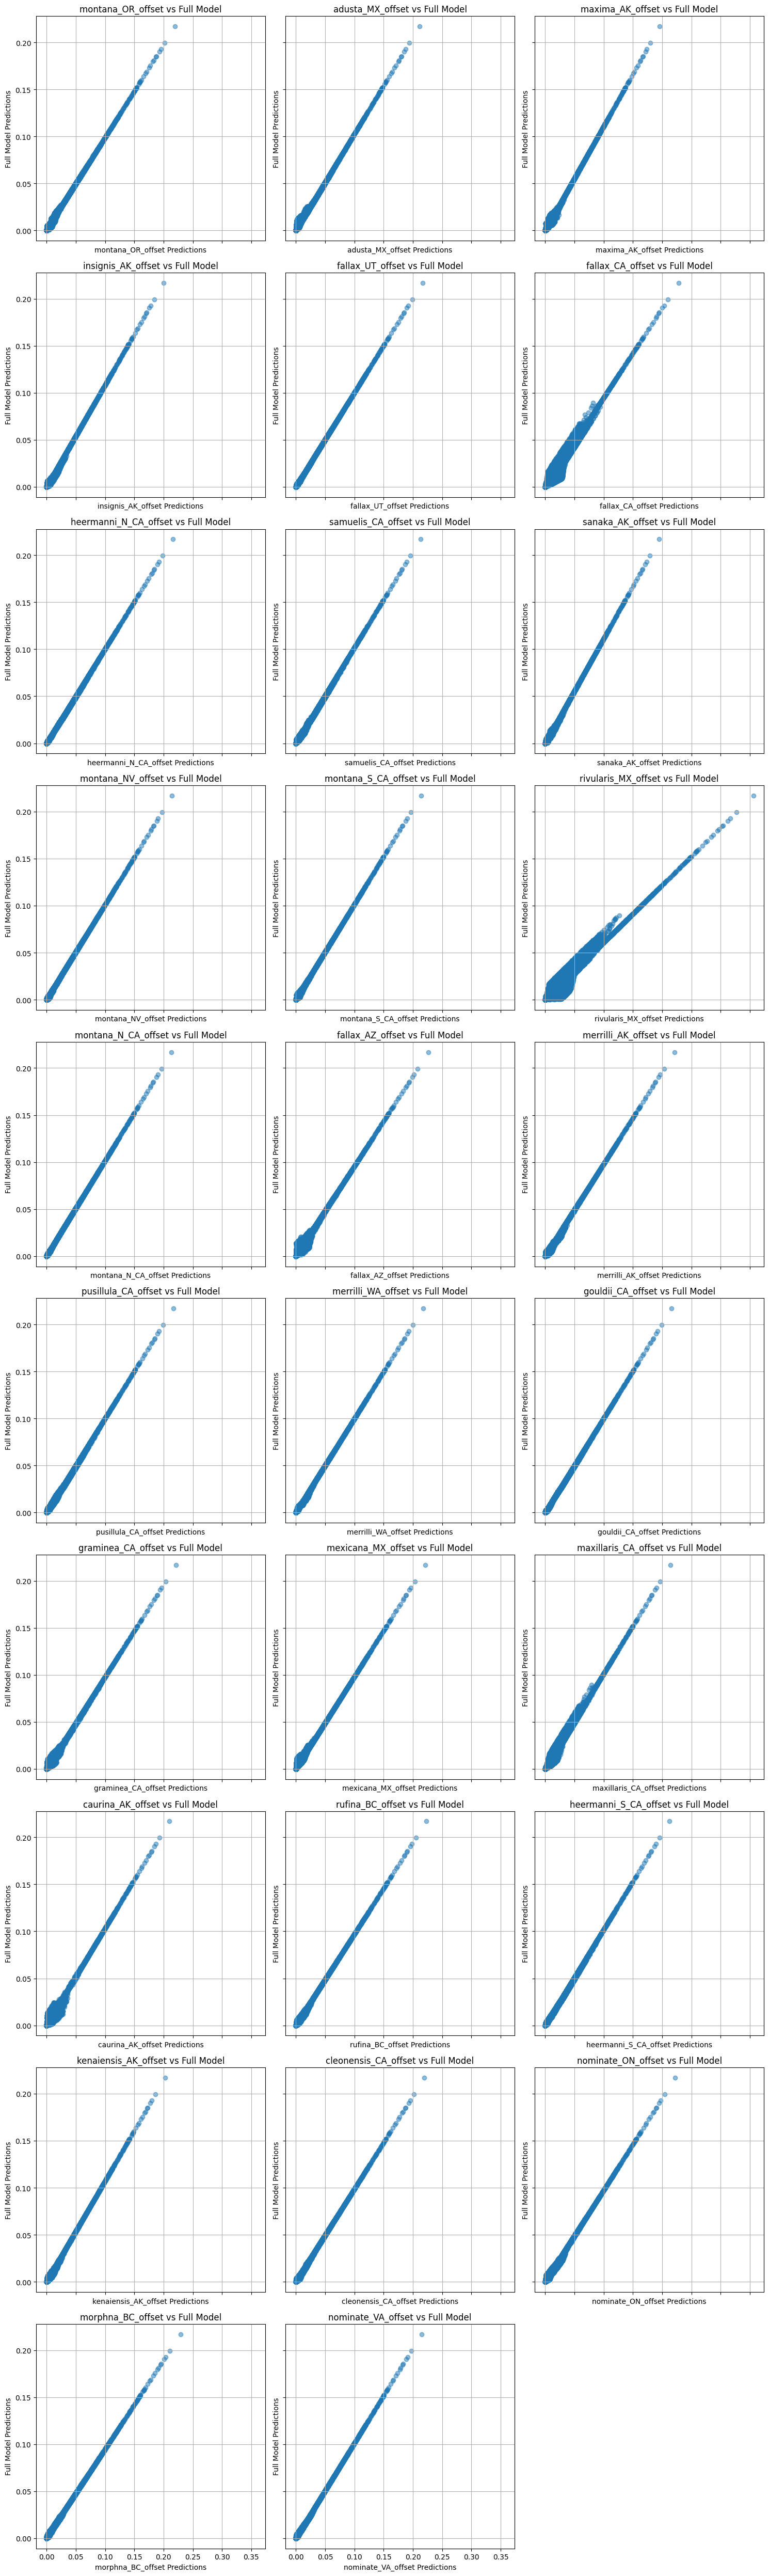

In [35]:
# Plotting predictions of each population against the full model
# Determine the number of rows and columns needed for the subplot
num_populations = len(offset.columns) - 1  # subtract 1 to exclude the full model column
num_cols = 3
num_rows = (num_populations + num_cols - 1) // num_cols  # calculate rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make iteration easier

for i, pop_col in enumerate(offset.columns[1:]):  # Skip the 'full_offset' column
    # Select the predictions for the population and the full model
    pop_predictions = offset[pop_col].values
    full_model_predictions = offset['full_offset'].values
    
    # Create scatter plot on the appropriate subplot
    ax = axes[i]
    ax.scatter(pop_predictions, full_model_predictions, alpha=0.5)
    ax.set_title(f'{pop_col} vs Full Model')
    ax.set_xlabel(f'{pop_col} Predictions')
    ax.set_ylabel('Full Model Predictions')
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## 5. Variable Importance

In [41]:
import subprocess

script_file = '/workdir/kcarbeck/extract_importance.R'
rdsfile = '/workdir/kcarbeck/data/training/west_full_gradient_forest_training.RDS'

command = ['Rscript', script_file, rdsfile]

subprocess.run(command, check=True)

[1] "wrote to outfile:"
[1] "/workdir/kcarbeck/data/training/west_full_gradient_forest_training_importances.txt"


CompletedProcess(args=['Rscript', '/workdir/kcarbeck/extract_importance.R', '/workdir/kcarbeck/data/training/west_full_gradient_forest_training.RDS'], returncode=0)

In [42]:
from concurrent.futures import ProcessPoolExecutor

In [46]:
import re

def get_pop_names(directory, pattern):
    # get a list of all files in the directory
    all_files = os.listdir(directory)
    # filter files based on the pattern
    filtered_files = [f for f in all_files if re.match(pattern, f)]
    # extract the population names
    pop_names = [re.sub(pattern, r'\1', f) for f in filtered_files]
    # remove duplicates and return
    return list(set(pop_names))


# directory where the files are stored
directory = '/workdir/kcarbeck/data/loocv/'

# regex pattern to match filenames and get population names (assumes names start with 'snpfile_snp_train_' followed by the pop name and '.txt')
pattern = r'snpfile_snp_train_(.+)\.txt'

# get the list of population names
pop_names = get_pop_names(directory, pattern)
print(pop_names) 

def run_r_script(pop_name):
    script_file = '/workdir/kcarbeck/extract_importance.R'
    rdsfile = f'/workdir/kcarbeck/data/loocv/training/west_loocv_{pop_name}_gradient_forest_training.RDS'
    command = ['Rscript', script_file, rdsfile]
    subprocess.run(command, check=True)

max_workers = 5
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # submit a job for each population name
    futures = [executor.submit(run_r_script, name) for name in pop_names]
    # wait for all jobs to complete
    for future in futures:
        future.result()

['nominate_ON', 'rivularis_MX', 'montana_OR', 'gouldii_CA', 'montana_N_CA', 'fallax_UT', 'mexicana_MX', 'fallax_CA', 'maxillaris_CA', 'graminea_CA', 'nominate_VA', 'sanaka_AK', 'cleonensis_CA', 'heermanni_S_CA', 'merrilli_WA', 'montana_NV', 'montana_S_CA', 'caurina_AK', 'rufina_BC', 'insignis_AK', 'pusillula_CA', 'adusta_MX', 'morphna_BC', 'kenaiensis_AK', 'fallax_AZ', 'samuelis_CA', 'heermanni_N_CA', 'maxima_AK', 'merrilli_AK']
[1] "wrote to outfile:"
[1] "/workdir/kcarbeck/data/loocv/training/west_loocv_nominate_ON_gradient_forest_training_importances.txt"
[1] "wrote to outfile:"
[1] "/workdir/kcarbeck/data/loocv/training/west_loocv_montana_N_CA_gradient_forest_training_importances.txt"
[1] "wrote to outfile:"
[1] "/workdir/kcarbeck/data/loocv/training/west_loocv_gouldii_CA_gradient_forest_training_importances.txt"
[1] "wrote to outfile:"
[1] "/workdir/kcarbeck/data/loocv/training/west_loocv_rivularis_MX_gradient_forest_training_importances.txt"
[1] "wrote to outfile:"
[1] "/workdir/

In [58]:
from pythonimports.myfigs import *
import matplotlib.lines as mlines
import copy
from matplotlib import colors as mcolors
import seaborn as sns

In [48]:
training_dir = '/workdir/kcarbeck/data/loocv/training'

# Initialize a dictionary to hold the DataFrames
importance_files = {}
pattern = r'west_loocv_(.*)_gradient_forest_training_importances.txt'

# List all files in the training directory
files = os.listdir(training_dir)

# Read each file into a DataFrame and store it with a key corresponding to the population name
for file in files:
    if file.endswith("_gradient_forest_training_importances.txt"):
        # Extract the population name from the file name
        match = re.search(pattern, file)
        if match:
            key = match.group(1)  # Population name, e.g., 'nominate_ON'
            # Read the file into a DataFrame
            file_path = os.path.join(training_dir, file)
            importance_files[key] = pd.read_table(file_path, sep='\t')

In [81]:
training_dir = '/workdir/kcarbeck/data/loocv/training'
full_model_dir = '/workdir/kcarbeck/data/training'  # Assuming this is the directory for the full model

# Initialize a dictionary to hold the DataFrames
importance_files = {}

# Add the full model's importance file
full_model_file = 'west_full_gradient_forest_training_importances.txt'
full_model_path = os.path.join(full_model_dir, full_model_file)
importance_files['full'] = pd.read_table(full_model_path, sep='\t')

# Regular expression pattern for LOOCV files
pattern = r'west_loocv_(.*)_gradient_forest_training_importances.txt'

# List all files in the training directory and add them to the dictionary
files = os.listdir(training_dir)
for file in files:
    if file.endswith("_gradient_forest_training_importances.txt"):
        # Extract the population name from the file name
        match = re.search(pattern, file)
        if match:
            key = match.group(1)  # Population name, e.g., 'nominate_ON'
            # Read the file into a DataFrame
            file_path = os.path.join(training_dir, file)
            importance_files[key] = pd.read_table(file_path, sep='\t')

In [82]:
print(importance_files)

{'full':       overall_importance  weighted_importance  accuracy_importance
DD_0            0.003261             0.052928             0.003261
DD18            0.003409             0.055258             0.003409
EMT             0.001849             0.032254             0.001849
MAT             0.004056             0.066854             0.004056
MSP             0.003078             0.055219             0.003078
RH              0.004287             0.064438             0.004287
SHM             0.004569             0.079339             0.004569
TD              0.002906             0.041023             0.002906, 'nominate_ON':       overall_importance  weighted_importance  accuracy_importance
DD_0            0.002973             0.050083             0.002973
DD18            0.004014             0.067452             0.004014
EMT             0.001755             0.032389             0.001755
MAT             0.003682             0.064127             0.003682
MSP             0.003041             

In [83]:
importance_files.keys()

dict_keys(['full', 'nominate_ON', 'montana_N_CA', 'gouldii_CA', 'rivularis_MX', 'montana_OR', 'maxillaris_CA', 'graminea_CA', 'fallax_UT', 'mexicana_MX', 'fallax_CA', 'nominate_VA', 'sanaka_AK', 'cleonensis_CA', 'heermanni_S_CA', 'merrilli_WA', 'montana_NV', 'montana_S_CA', 'rufina_BC', 'caurina_AK', 'insignis_AK', 'adusta_MX', 'pusillula_CA', 'morphna_BC', 'kenaiensis_AK', 'fallax_AZ', 'samuelis_CA', 'heermanni_N_CA', 'maxima_AK', 'merrilli_AK'])

In [84]:
# Preparing the data for plotting
plot_data = {}
for population, df in importance_files.items():
    for var in df.index:
        if var not in plot_data:
            plot_data[var] = {}
        plot_data[var][population] = df.loc[var, 'overall_importance']  # Change to 'weighted_importance' or 'accuracy_importance' as needed

# Converting to DataFrame for easy plotting
plot_df = pd.DataFrame(plot_data)

print(plot_df)

                    DD_0      DD18       EMT       MAT       MSP        RH  \
full            0.003261  0.003409  0.001849  0.004056  0.003078  0.004287   
nominate_ON     0.002973  0.004014  0.001755  0.003682  0.003041  0.004310   
montana_N_CA    0.003372  0.003237  0.001773  0.004073  0.003015  0.004312   
gouldii_CA      0.003240  0.003456  0.001790  0.004098  0.003094  0.004365   
rivularis_MX    0.003057  0.003175  0.001645  0.003920  0.002963  0.004275   
montana_OR      0.003273  0.003356  0.001797  0.004032  0.003124  0.004250   
maxillaris_CA   0.003242  0.003522  0.001785  0.004065  0.003045  0.004363   
graminea_CA     0.003285  0.003472  0.001760  0.004016  0.003042  0.004377   
fallax_UT       0.003360  0.003421  0.001877  0.004096  0.003136  0.004430   
mexicana_MX     0.002265  0.003562  0.001620  0.003711  0.002786  0.003739   
fallax_CA       0.003275  0.003250  0.001715  0.003955  0.003072  0.004328   
nominate_VA     0.003274  0.003434  0.001639  0.003941  0.002923

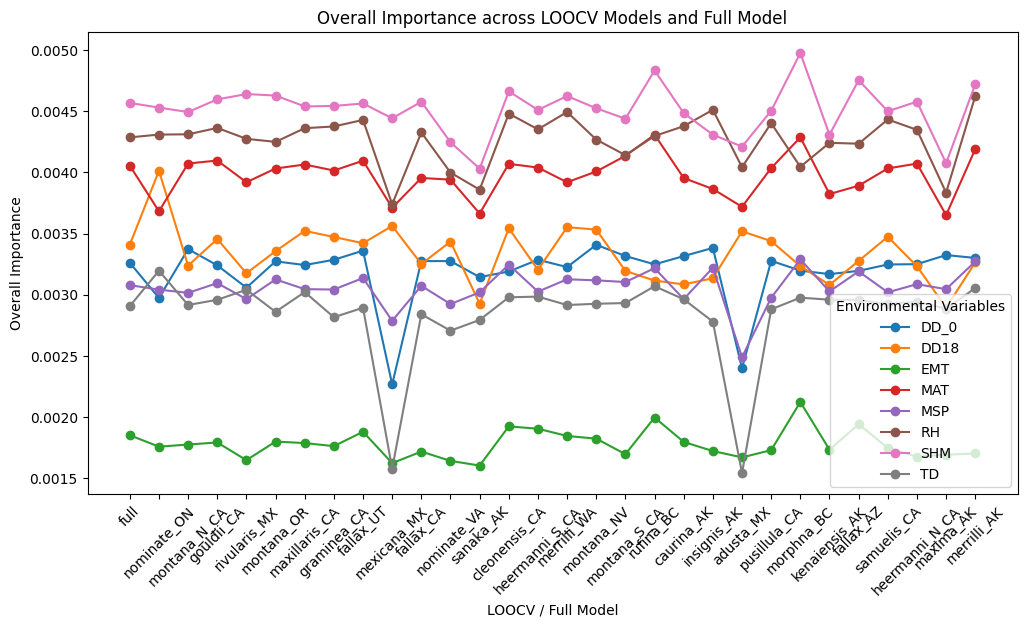

In [85]:
# Plotting
plt.figure(figsize=(12, 6))
for var in plot_df.columns:
    plt.plot(plot_df.index, plot_df[var], marker='o', label=var)

plt.xlabel('LOOCV / Full Model')
plt.ylabel('Overall Importance')  # Change as per the metric
plt.title('Overall Importance across LOOCV Models and Full Model')
plt.legend(title='Environmental Variables')
plt.xticks(rotation=45)
plt.show()


In [86]:
import matplotlib.colors as mcolors

In [147]:
def create_ranked_importance_plots(importance_files, importance='overall_importance',
                                   ncols=6, save_path=None):
    """Create side-by-side horizontal bar plots of ordered importance scores."""
    
    # Ensure 'full' is included and at the beginning if it's not already
    if 'full' not in importance_files:
        # Assuming the full model file is in the same directory but it was not added before
        full_model_path = os.path.join(training_dir, 'west_full_gradient_forest_training_importances.txt')
        importance_files['full'] = pd.read_table(full_model_path, sep='\t')
    
    # Sort so 'full' is first
    importance_files = {k: importance_files[k] for k in sorted(importance_files, key=lambda x: x != 'full')}
    
    # Set custom colors, making 'full' grey and the rest blue
    custom_colors = ['grey' if key == 'full' else 'blue' for key in importance_files.keys()]
    
    # Calculate how many rows and columns we need
    nrows = int(np.ceil(len(importance_files) / ncols))
    
    # Create a subplot for each feature importance file
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 10), sharey=True)
    axs = axs.flatten()  # Flatten the array for easier iteration
    
    # Determine the maximum importance value for consistent plot ranges
    max_importance = max(df[importance].max() for df in importance_files.values())
    
    # Plot each feature importance in its own subplot
    for ax, (population, df), color in zip(axs, importance_files.items(), custom_colors):
        # Sort the DataFrame by the specified importance metric in descending order
        sorted_df = df.sort_values(by=importance, ascending=True)
        ax.barh(sorted_df.index, sorted_df[importance], color=color)
        ax.set_title(population, fontsize=24)
        ax.set_xlim(0, max_importance)
        ax.tick_params(axis='x', labelsize=22)  # Increase x-axis font size
        ax.tick_params(axis='y', labelsize=22)  # Increase y-axis font size

    # Hide any unused subplots
    for i in range(len(importance_files), nrows * ncols):
        fig.delaxes(axs[i])
    
    # Set common labels and title
    #plt.subplots_adjust(top=0.8, bottom=0.2, hspace=0.4, wspace=0.35)
    fig.text(0.5, -0.02, importance.replace('_', ' ').capitalize(), ha='center', fontsize=30)
    fig.text(0.5, 1.01, 'Ranked Importance', ha='center', fontsize=30)
    
    # Adjust the layout and save the figure if a path is provided
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

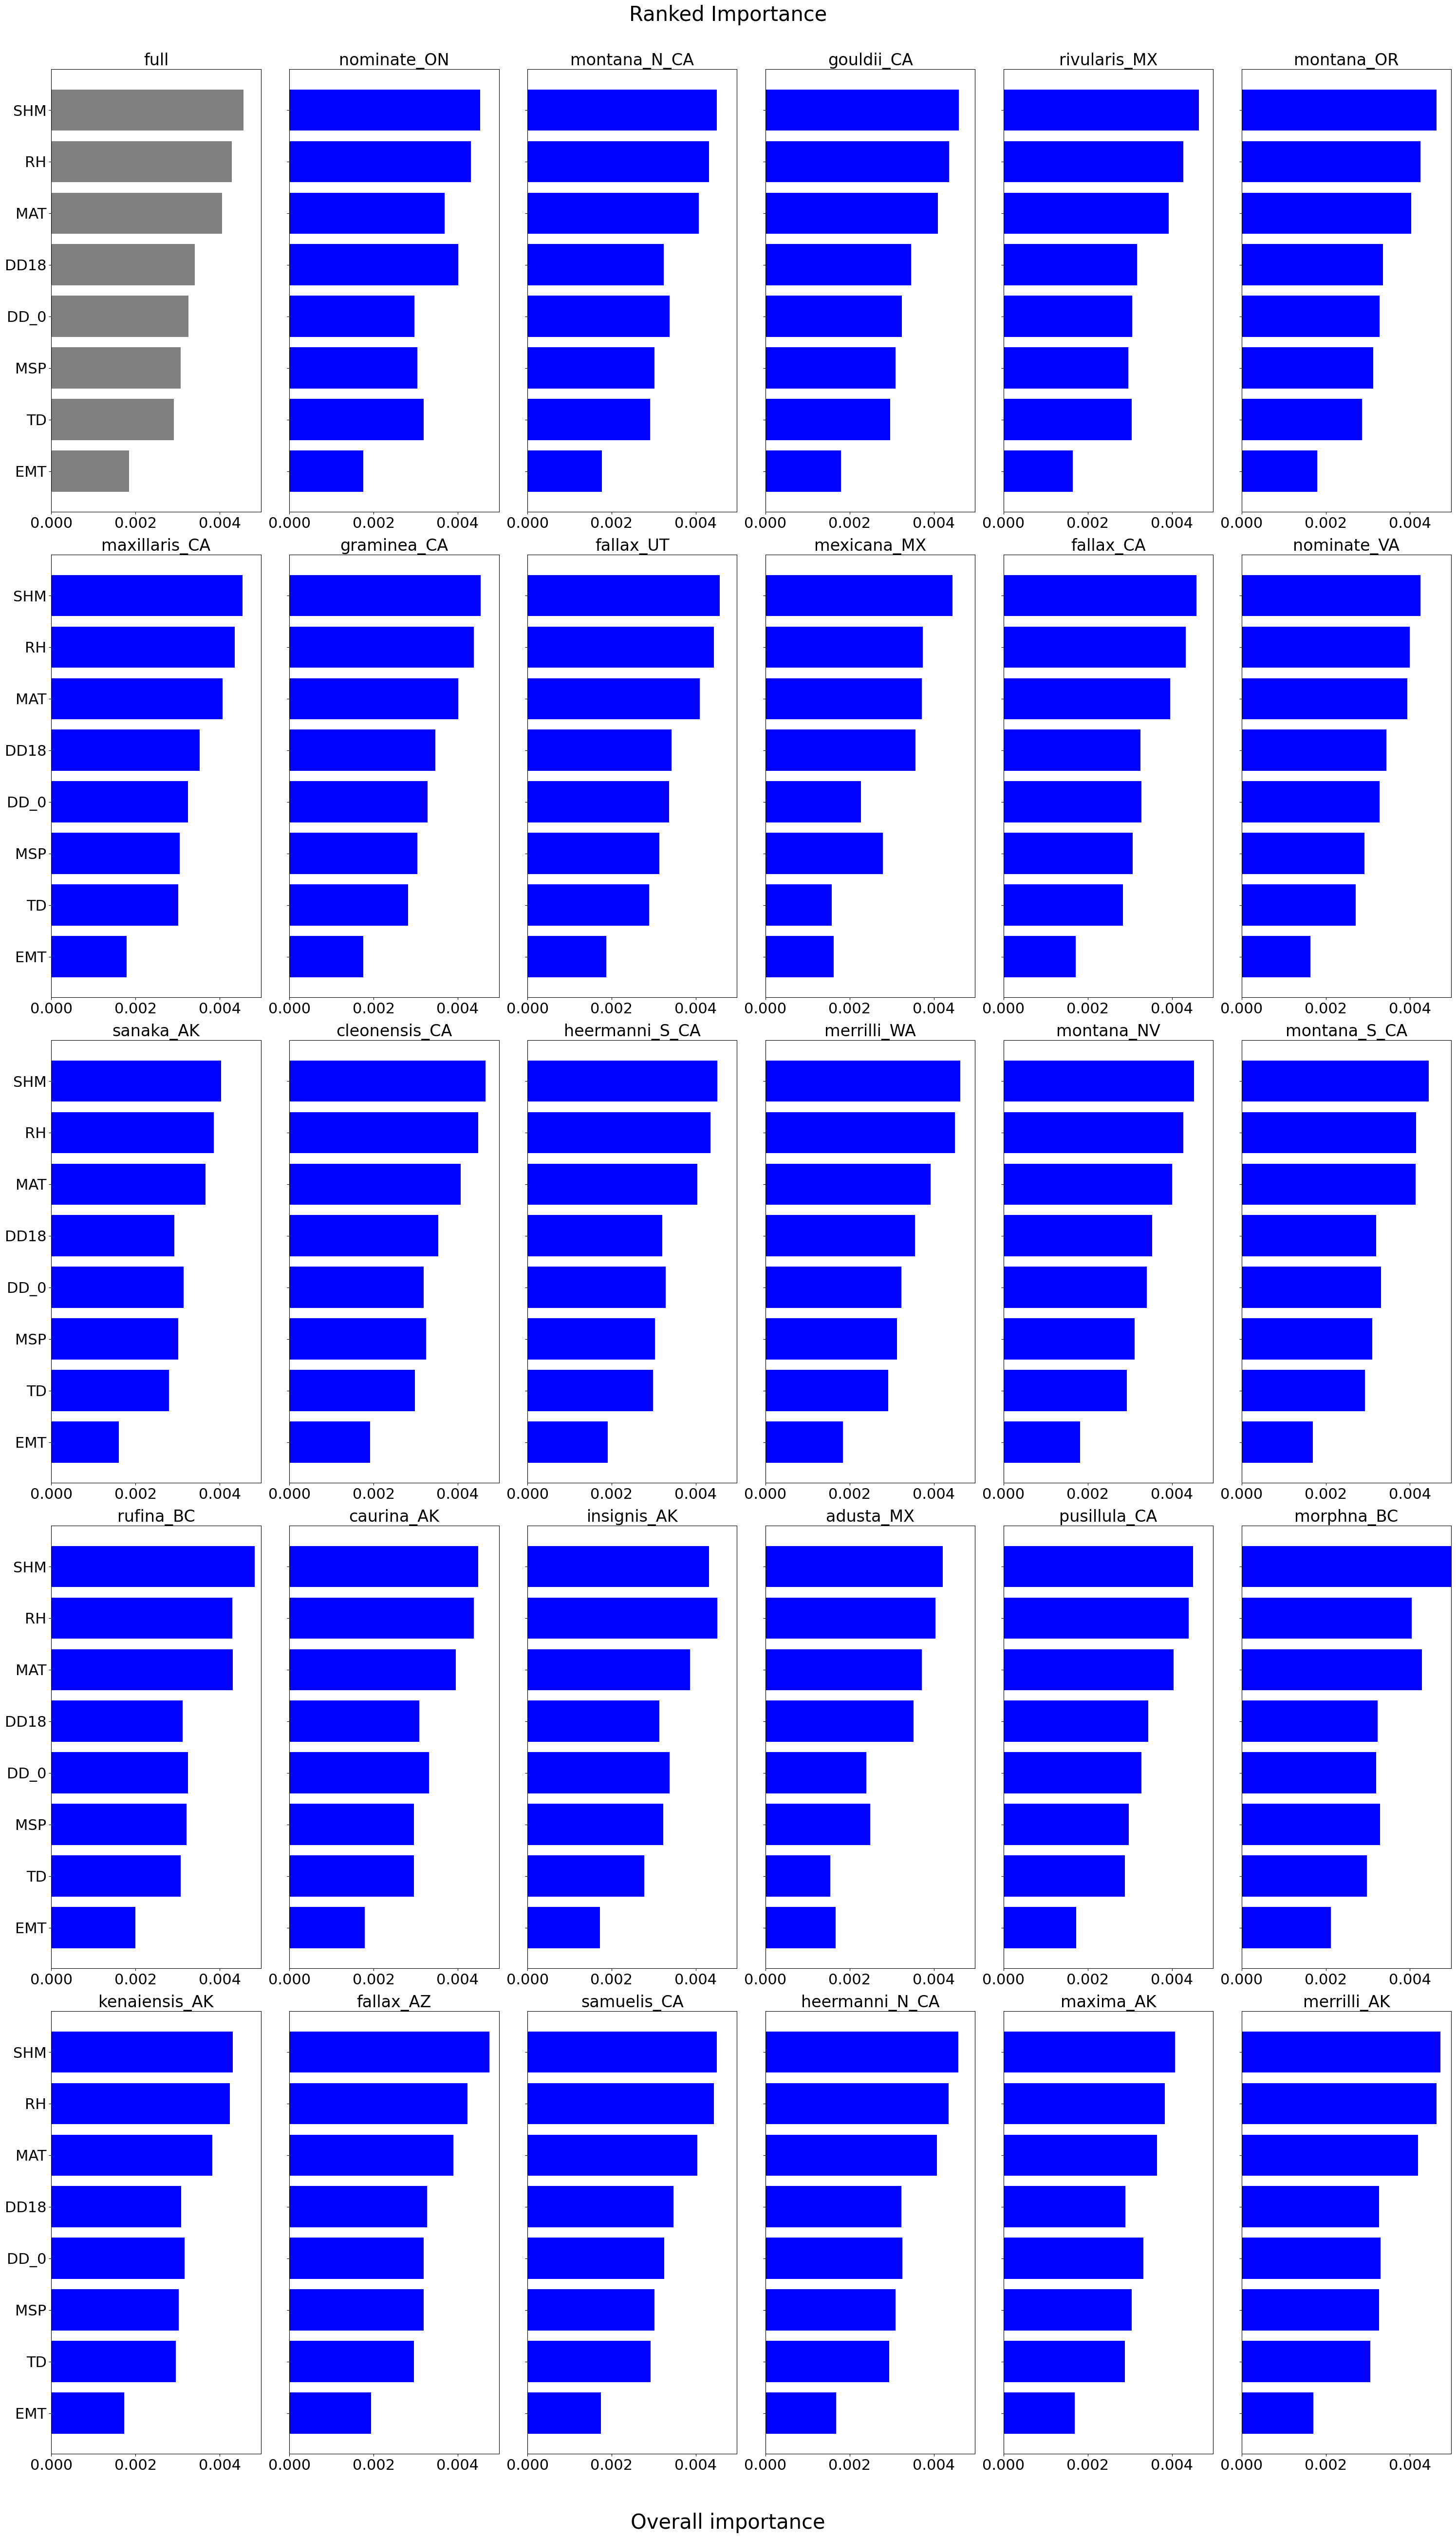

In [148]:
save_path = '/workdir/kcarbeck/data/loocv/plots/overall_importance.png'

# Assuming your `importance_files` is a dictionary with keys as pop names and values as DataFrames
create_ranked_importance_plots(importance_files, 'overall_importance',ncols=6, save_path=save_path)

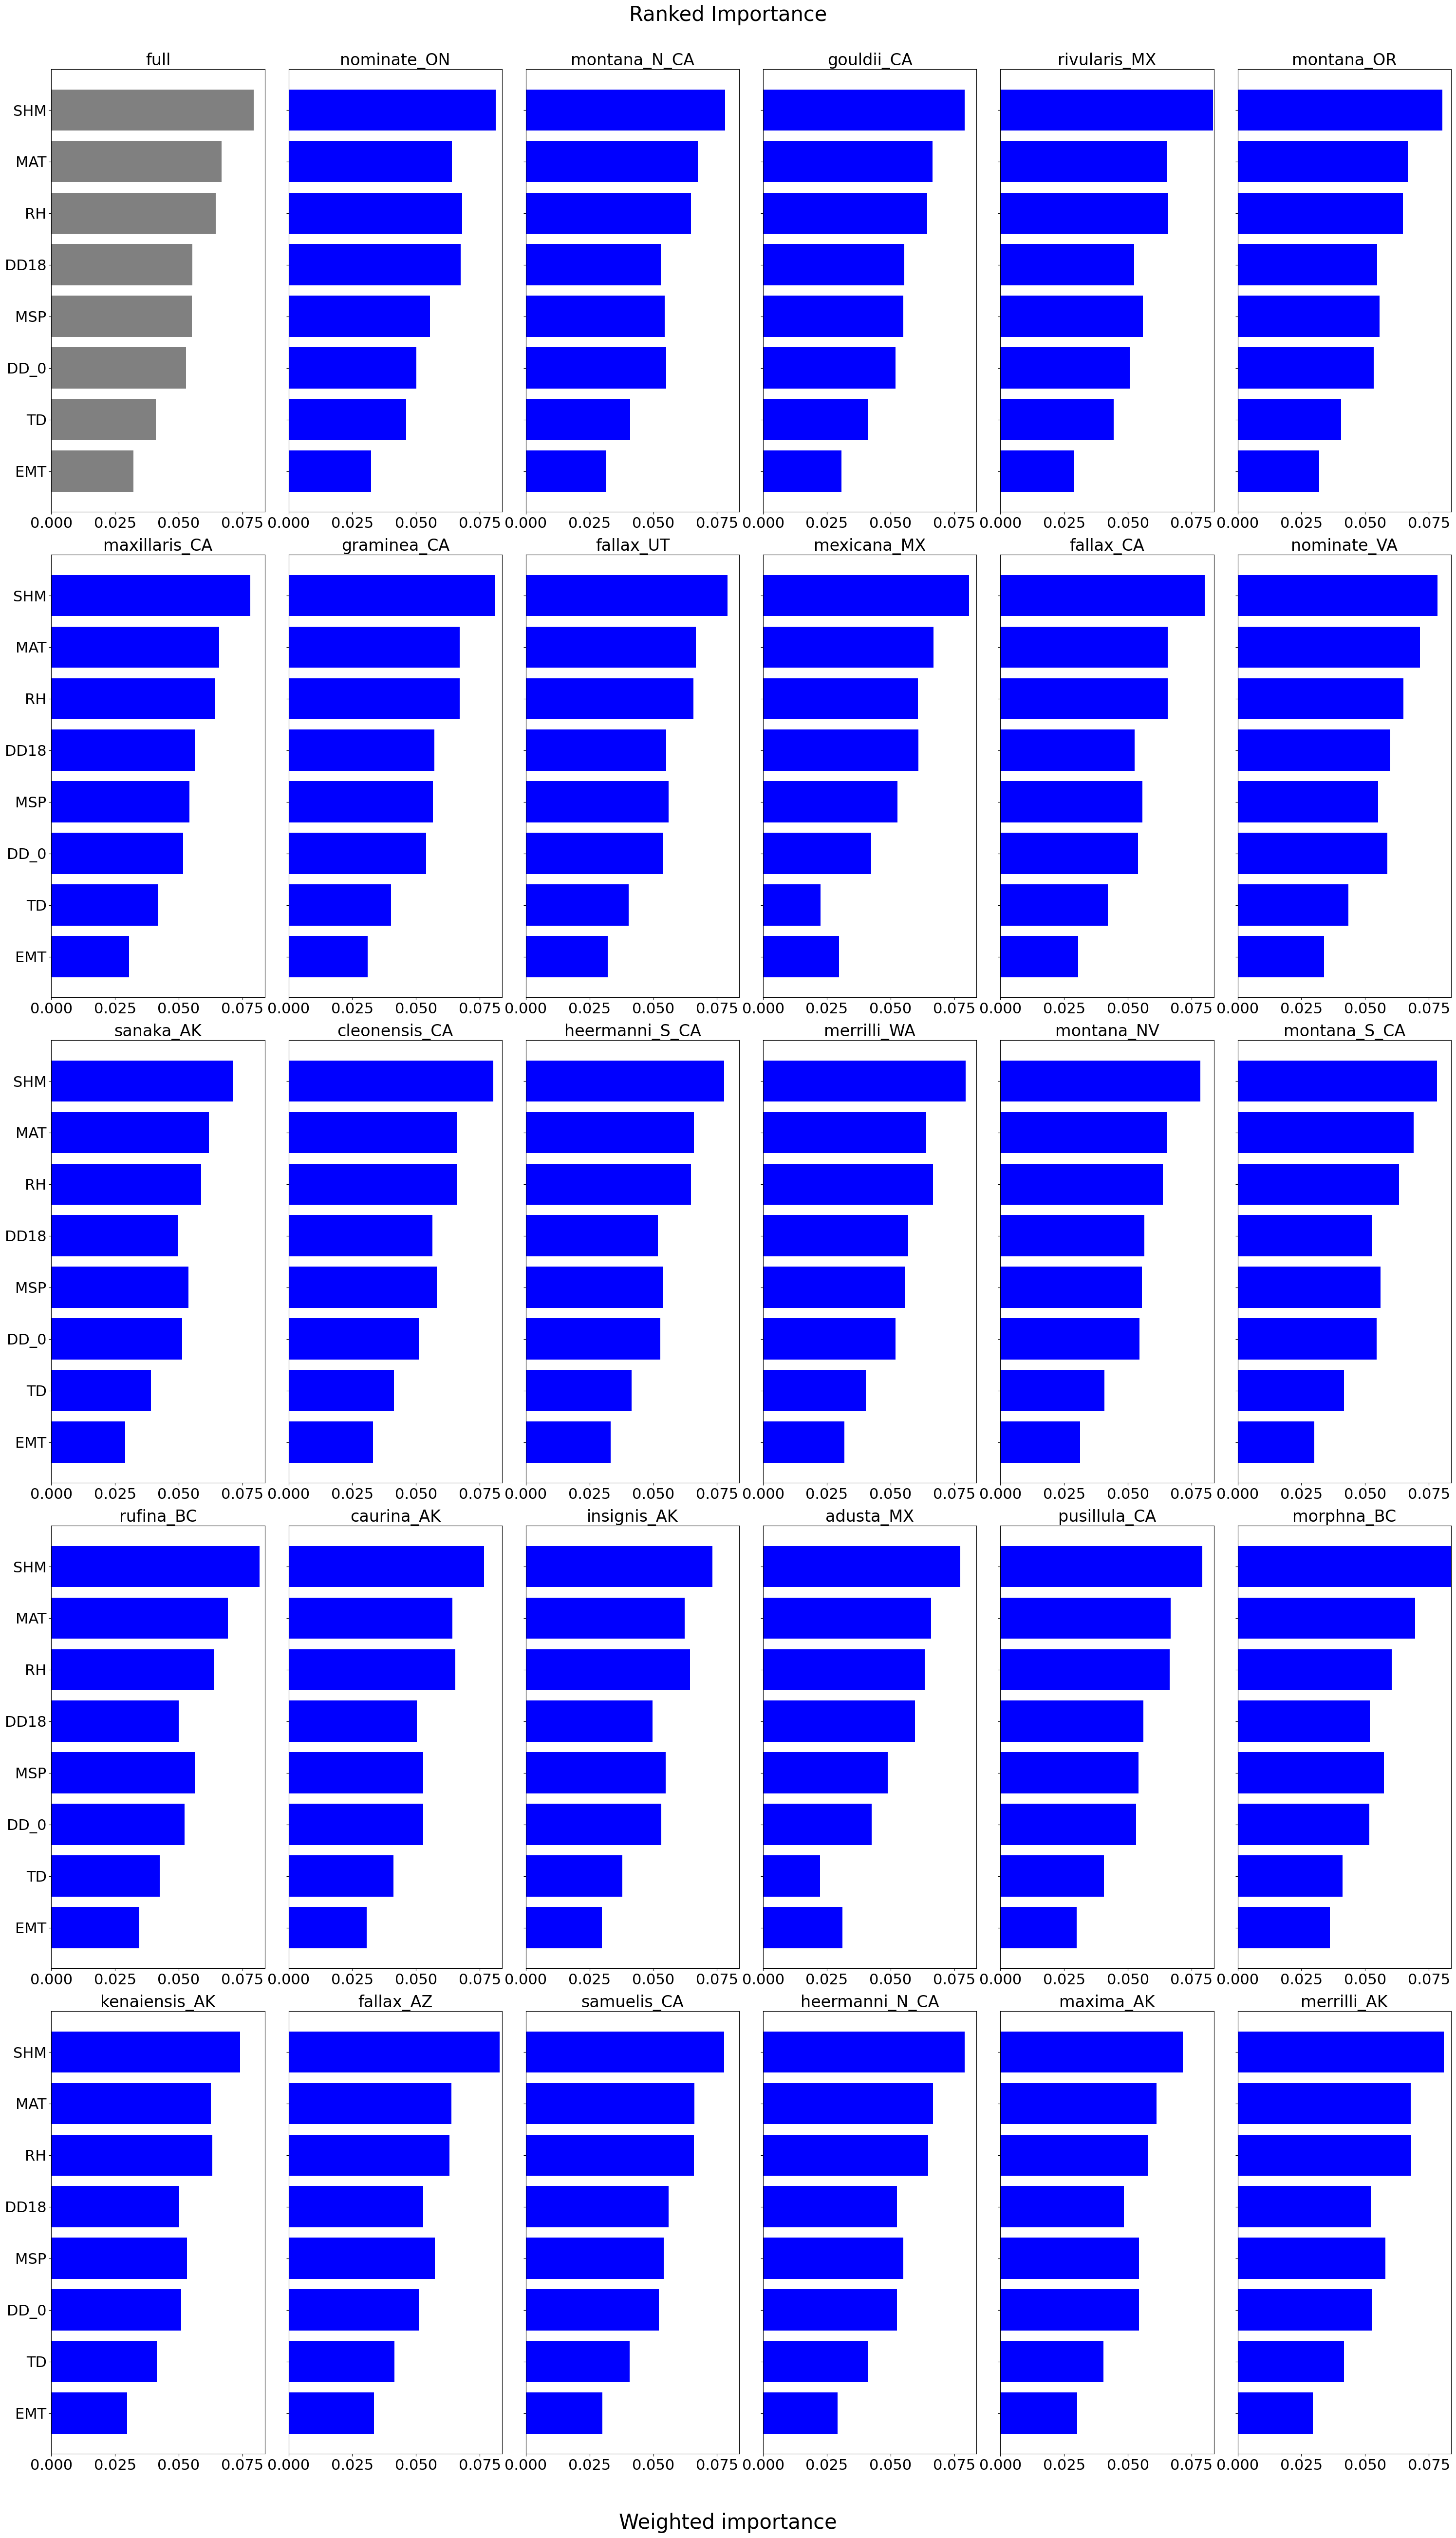

In [149]:
save_path = '/workdir/kcarbeck/data/loocv/plots/weighted_importance.png'

# Assuming your `importance_files` is a dictionary with keys as kfold names and values as DataFrames
create_ranked_importance_plots(importance_files, 'weighted_importance', 
                               ncols=6, save_path=save_path)

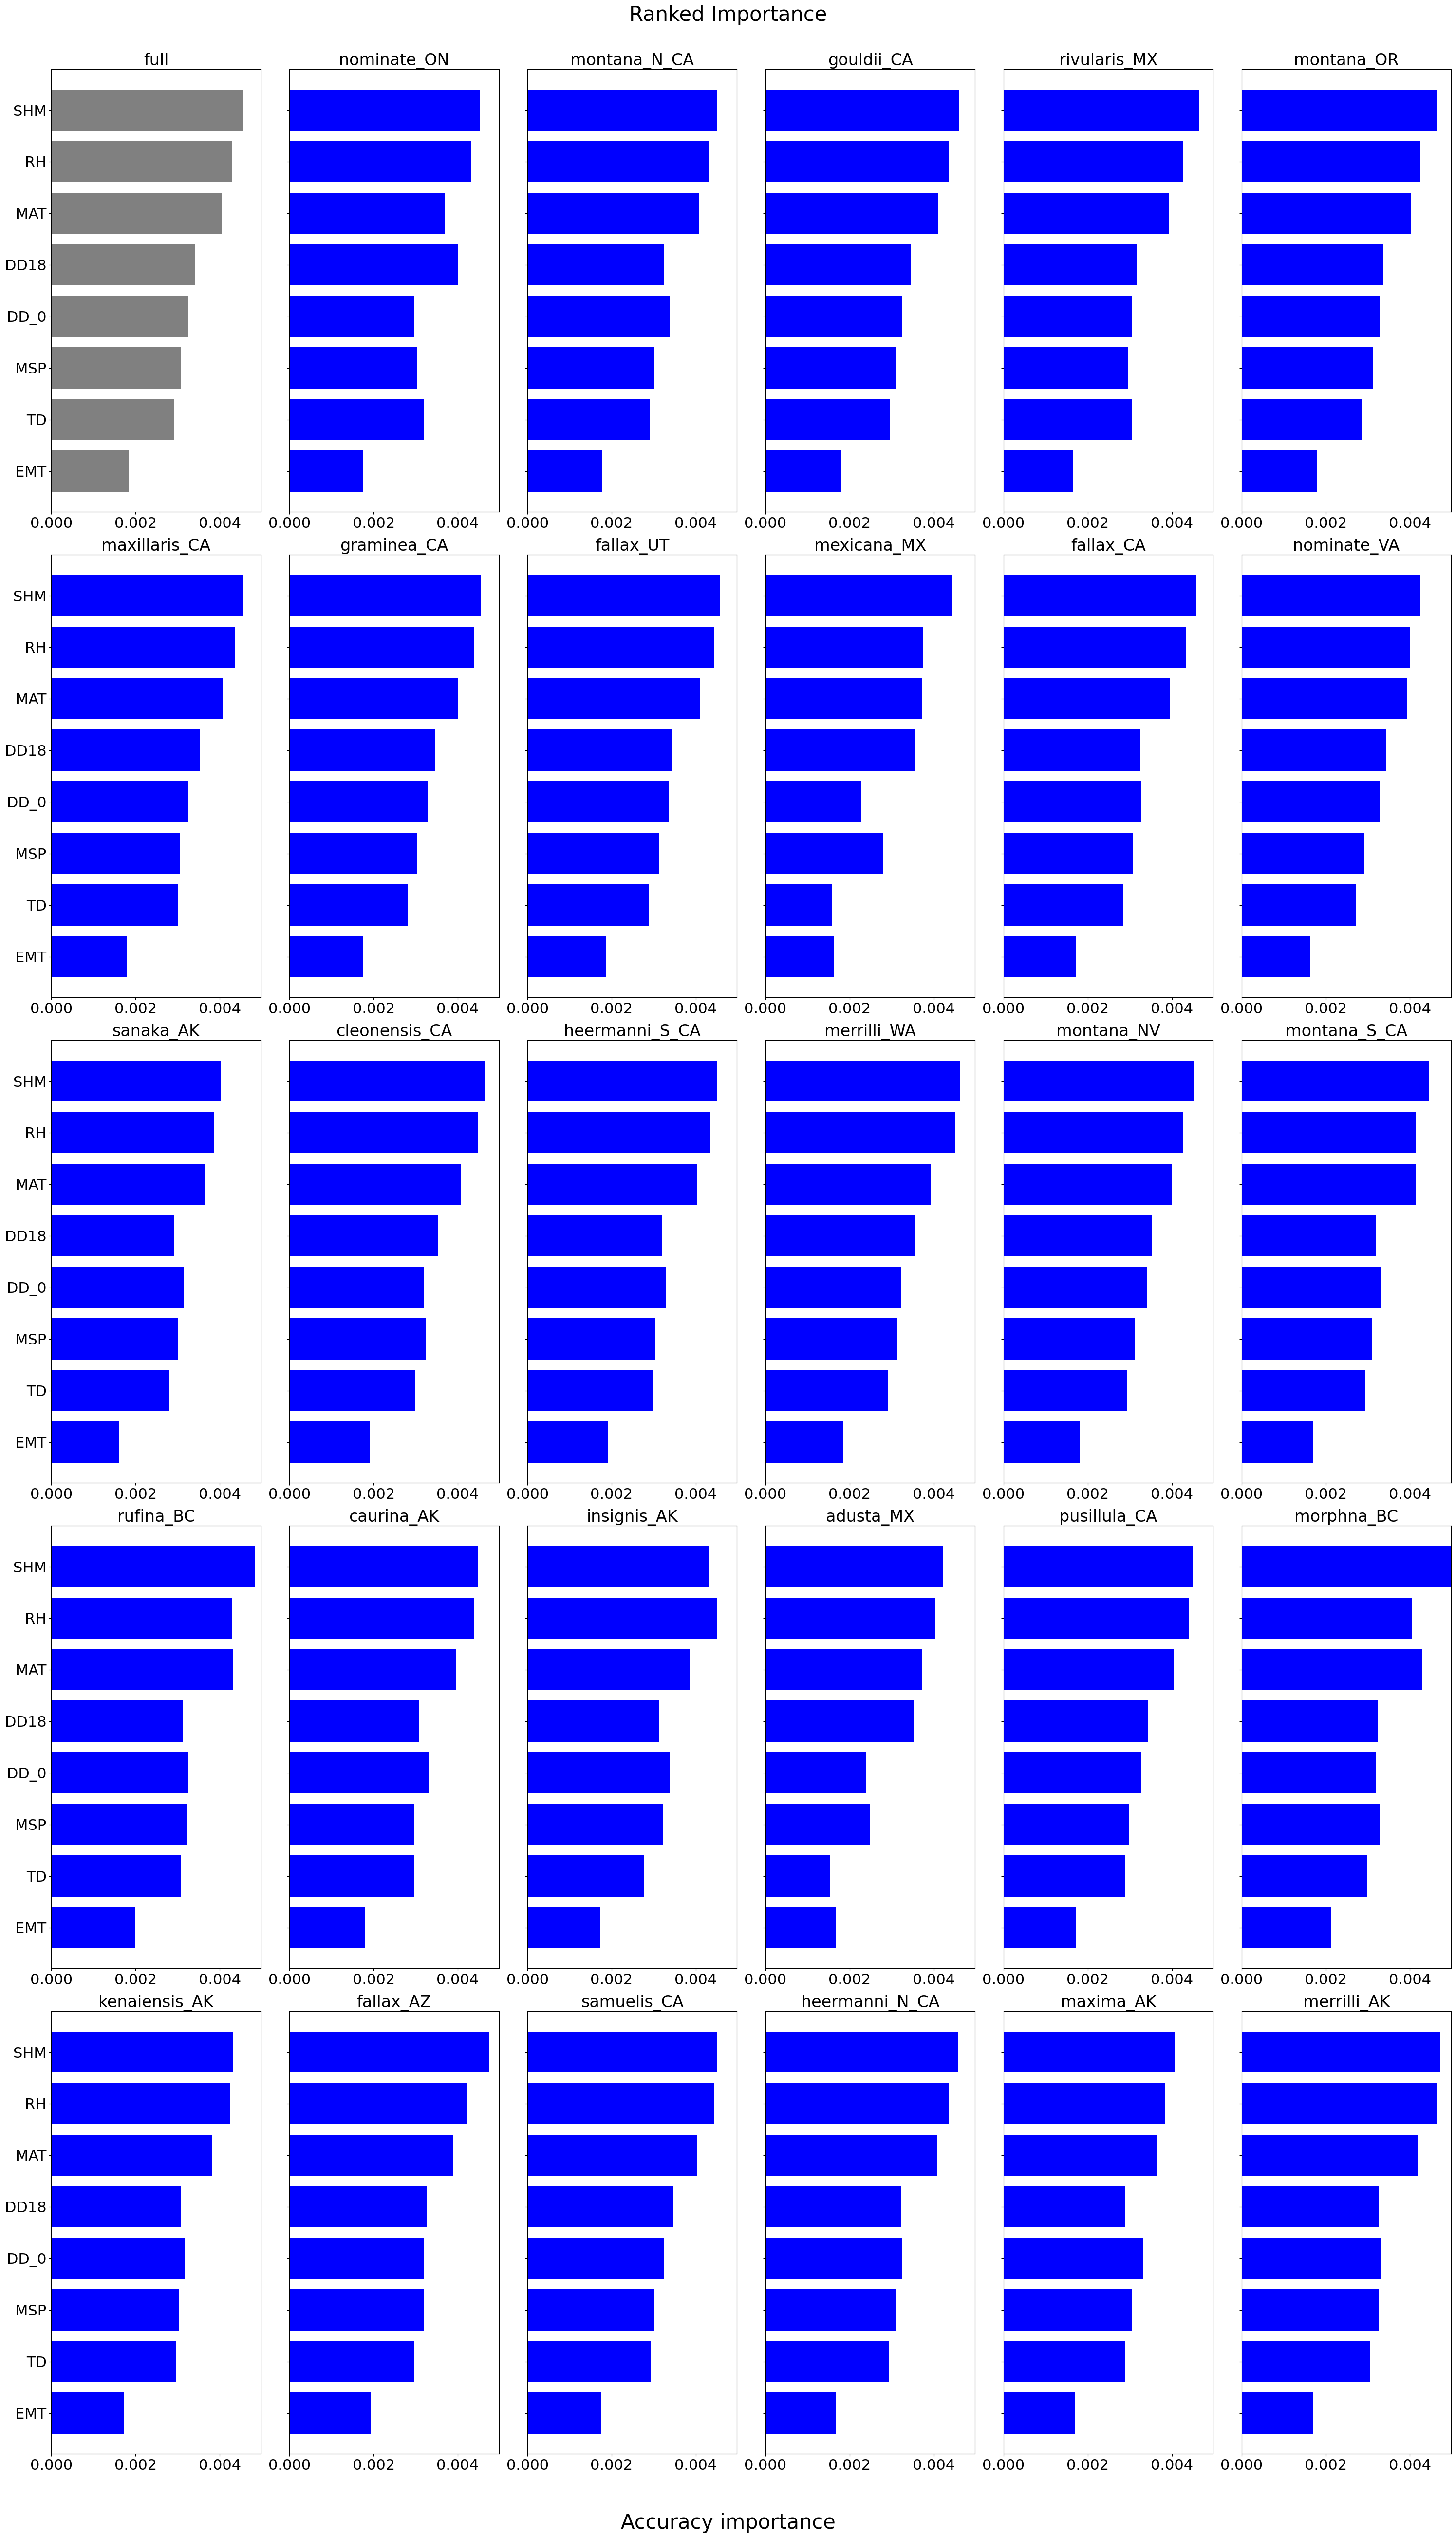

In [150]:
save_path = '/workdir/kcarbeck/data/loocv/plots/accuracy_importance.png'

# Assuming your `importance_files` is a dictionary with keys as kfold names and values as DataFrames
create_ranked_importance_plots(importance_files, 'accuracy_importance', 
                               ncols=6, save_path=save_path)